In [1]:
#get aws keys
import csv
with open('private/accessKeys.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    for line in readCSV:
        access_key = line[0]
        secret_key = line[1]

In [2]:
#use pyathenajdbc to query an athena table
from pyathenajdbc import connect
import pandas as pd
import numpy as np
connection = connect(access_key=access_key, secret_key=secret_key, s3_staging_dir='s3://spark-one-off/pyathena/',
    region_name='us-west-2')

In [3]:
#read train table into dataframe...is slow, likely due to pyathenajdbc
query = 'select * from oneoff.train'
train = pd.read_sql(query, connection)
print train.dtypes
train.head(5)

id           int64
ran_num    float64
class       object
xscore     float64
oscore     float64
bscore     float64
x0         float64
y0         float64
x          float64
y          float64
dtype: object


,id,ran_num,class,xscore,oscore,bscore,x0,y0,x,y
0,0,0.715786,B,0.0,0.0,1.0,1.763768,6.607155,1.592436,6.471761
1,1,0.253970,O,0.0,1.0,0.0,-0.088358,1.626997,-0.393750,2.040420
2,2,0.527179,B,0.0,0.0,1.0,7.066441,-1.146829,6.957010,-1.017307
3,3,0.194195,O,0.0,1.0,0.0,1.592799,2.888143,1.242120,2.903483
4,4,0.267423,B,0.0,0.0,1.0,-2.896532,4.824296,-2.673647,5.006567


In [4]:
#get indices of X, O and B classes
print 'number of records in train = ', len(train)
idx_x = train['class'] == 'X'
idx_o = train['class'] == 'O'
idx_b = train['class'] == 'B'
print 'X fraction = ', idx_x.sum()*1.0/len(idx_x)
print 'O fraction = ', idx_o.sum()*1.0/len(idx_o)
print 'B fraction = ', idx_b.sum()*1.0/len(idx_b)
print 'B/O ratio = ', idx_b.sum()*1.0/idx_o.sum()

number of records in train =  30000
X fraction =  0.1336
O fraction =  0.129
B fraction =  0.7374
B/O ratio =  5.71627906977


In [5]:
#prep plots
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.2, font='DejaVu Sans')

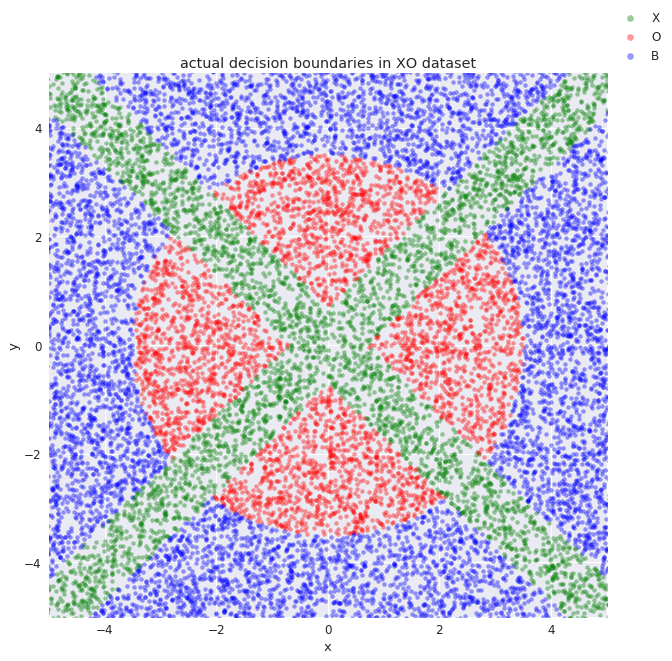

In [6]:
#scatterplot of jitterless (x0,y0) data, to show actual decision boundaries
f, ax = plt.subplots(figsize=(10, 10))
df = train
clr = 'green'
idx = idx_x
xp = df['x0'][idx]
yp = df['y0'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.4, 's': 20}, color=clr, label='X')
clr = 'red'
idx = idx_o
xp = df['x0'][idx]
yp = df['y0'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.4, 's': 20}, color=clr, label='O')
clr = 'blue'
idx = idx_b
xp = df['x0'][idx]
yp = df['y0'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.4, 's': 20}, color=clr, label='B')
p.set_title('actual decision boundaries in XO dataset')
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)

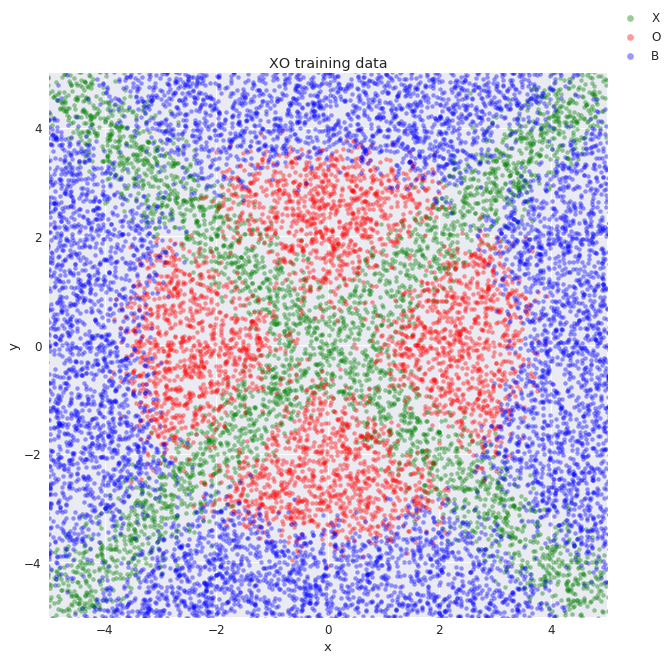

In [7]:
#scatterplot of training (x,y) data
f, ax = plt.subplots(figsize=(10, 10))
df = train
clr = 'green'
idx = idx_x
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.4, 's': 20}, color=clr, label='X')
clr = 'red'
idx = idx_o
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.4, 's': 20}, color=clr, label='O')
clr = 'blue'
idx = idx_b
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.4, 's': 20}, color=clr, label='B')
p.set_title('XO training data')
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)

In [8]:
#read grid table into dataframe...slow...
query = 'select * from oneoff.grid'
grid = pd.read_sql(query, connection)
print grid.dtypes
print 'number of records in grid = ', len(grid)
grid.head(5)

x             float64
y             float64
class_pred     object
dtype: object
number of records in grid =  40401


,x,y,class_pred
0,3.95,0.05,B
1,4.00,0.05,B
2,4.05,0.05,B
3,4.10,0.05,B
4,4.15,0.05,B


In [9]:
print 'number of records in grid = ', len(grid)

number of records in grid =  40401


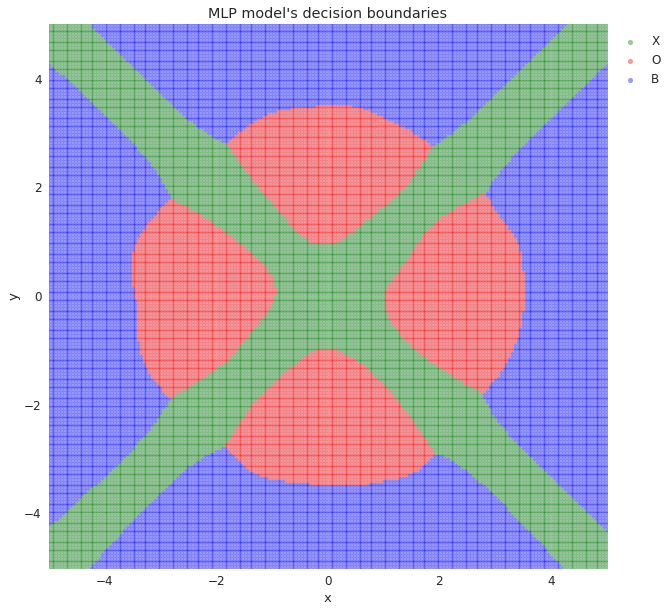

In [10]:
#plot the mlp model's decision surface
f, ax = plt.subplots(figsize=(10, 10))
df = grid
clr = 'green'
idx = df['class_pred'] == 'X'
xp = df['x'][idx]
yp = df['y'][idx]
p = sns.regplot(xp, yp, ax=ax, fit_reg=False, scatter_kws={'alpha':0.4, 's': 12}, color=clr, label='X')
clr = 'red'
idx = df['class_pred'] == 'O'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.4, 's': 12}, color=clr, label='O')
clr = 'blue'
idx = df['class_pred'] == 'B'
xp = df['x'][idx]
yp = df['y'][idx]
sns.regplot(xp, yp, ax=p, fit_reg=False, scatter_kws={'alpha':0.4, 's': 12}, color=clr, label='B')
p.set_title("MLP model's decision boundaries")
p.set_xlabel('x')
p.set_ylabel('y')
p.set_xlim(-5.0, 5.0)
p.set_ylim(-5.0, 5.0)
scat_plot = p.legend(bbox_to_anchor=(1.0, 1.0), markerscale=1.5)